## Discrete Short-Time Fourier Transform (STFT)

Following Section 2.1.4 of [Müller, FMP, Springer 2015], we discuss in this notebook a discrete version of the short-time Fourier transform (STFT).

### Missing Time Localization
The Fourier transform yields frequency information that is averaged over the entire time domain. However, the information on when these frequencies occur is hidden in the transform. This phenomenon is illustrated by the following example.

In [ ]:
#import sys
#!conda install --yes --prefix {sys.prefix} <package_name>

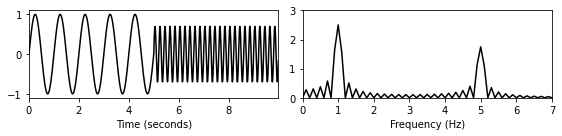

In [3]:
import os
import numpy as np
import matplotlib
from  matplotlib import pyplot as plt
#import librosa
#from ipywidgets import interact, fixed, FloatSlider
#import IPython.display as ipd
%matplotlib inline

Fs = 128 #sampling frequency
duration = 10 #number of seconds
omega1 = 1
omega2 = 5
N = int(duration * Fs)
t = np.arange(N) / Fs
t1 = t[:N//2]
t2 = t[N//2:]

x1 = 1.0 * np.sin(2 * np.pi * omega1 * t1)
x2 = 0.7 * np.sin(2 * np.pi * omega2 * t2)
x = np.concatenate((x1, x2))

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(t, x, c='k')
plt.xlim([min(t), max(t)])
plt.xlabel('Time (seconds)')

plt.subplot(1, 2, 2)
X = np.abs(np.fft.fft(x)) / Fs
freq = np.fft.fftfreq(N, d=1/Fs)
X = X[:N//2]
freq = freq[:N//2]
plt.plot(freq, X, c='k')
plt.xlim([0, 7])
plt.ylim([0, 3])
plt.xlabel('Frequency (Hz)')
plt.tight_layout()

### Basic Idea
To recover the hidden time information, Dennis Gabor introduced in the year 1946 the **short-time Fourier transform (STFT**). Instead of considering the entire signal, the main idea of the STFT is to consider only a **small section** of the signal. To this end, one fixes a so-called **window function**, which is a function that is nonzero for only a short period of time (defining the considered section). The original signal is then multiplied with the window function to yield a windowed signal. To obtain frequency information at different time instances, one shifts the window function across time and computes a Fourier transform for each of the resulting windowed signals. This idea is illustrated by the next example.

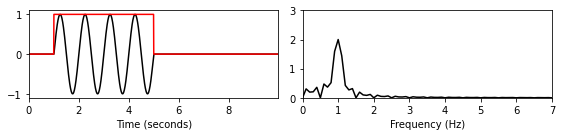

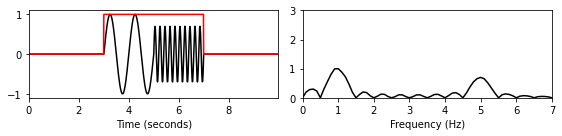

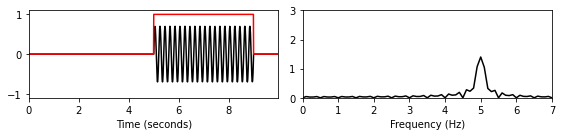

In [4]:
def windowed_ft(t, x, Fs, w_pos_sec, w_len):
    '''
    t = time of the signal
    x = value of the signal
    Fs = sampling frequency of the signal
    w_pos_sec = time at which the window is starting to be positioned
    w_len = length of the window
    '''
    
    N = len(x)
    w_pos = int(Fs * w_pos_sec)
    w_padded = np.zeros(N)
    w_padded[w_pos:w_pos + w_len] = 1 #window function
    x = x * w_padded    #modulated/windowed signal
    plt.figure(figsize=(8, 2))

    plt.subplot(1, 2, 1)
    plt.plot(t, x, c='k')
    plt.plot(t, w_padded, c='r')
    plt.xlim([min(t), max(t)])
    plt.ylim([-1.1, 1.1])
    plt.xlabel('Time (seconds)')

    plt.subplot(1, 2, 2)
    X = np.abs(np.fft.fft(x)) / Fs
    freq = np.fft.fftfreq(N, d=1/Fs)
    X = X[:N//2]
    freq = freq[:N//2]
    plt.plot(freq, X, c='k')
    plt.xlim([0, 7])
    plt.ylim([0, 3])
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

    
w_len = 4 * Fs
windowed_ft(t, x, Fs, w_pos_sec=1, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=3, w_len=w_len)
windowed_ft(t, x, Fs, w_pos_sec=5, w_len=w_len)

#print('Interactive interface for experimenting with different window shifts:')
#interact(windowed_ft,
#         w_pos_sec=FloatSlider(min=0, max=duration-(w_len/Fs), step=0.1, 
#                continuous_update=False, value=1.7, description='Position'),
#                t=fixed(t), x=fixed(x), Fs=fixed(Fs), w_len=fixed(w_len));


It is important to note that the **STFT reflects not only the properties of the original signal but also those of the window function**. First of all, the STFT depends on the length of the window, which determines the size of the section. Then, the STFT is influenced by the shape of the window. For example, the sharp edges of the rectangular window typically introduce "ripple" artifacts. We discuss such issues in more detail later.

### Formal definition of Discrete DFT
 [Source to Read More: ](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2_STFT-Basic.html#Formal-Definition-of-the-Discrete-STFT)

## Spectrogram

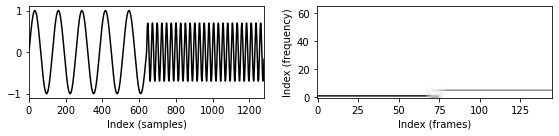

In [10]:
def stft_basic(x, w, H, only_positive_frequencies=False):
    """Compute a basic version of the discrete short-time Fourier transform (STFT)

    Notebook: C2/C2_STFT-Basic.ipynb

    Args:
        x: Signal to be transformed
        w: Window function
        H: Hopsize, determines the step size in which the window is to be shifted across the signal.
        only_positive_frequencies: Return only positive frequency part of spectrum (non-invertible)

    Returns:
        X: The discrete short-time Fourier transform of function x
    """
    N = len(w)
    L = len(x)
    M = np.floor((L - N) / H).astype(int) + 1 #NUMBER OF CALCULATIONS OF THE STFTs
    X = np.zeros((N, M), dtype='complex')
    
    
    for m in range(M):
        x_win = x[m * H : m * H + N] * w #m-th copy of windowed signal
        X_win = np.fft.fft(x_win) #stft of the windowed signal
        X[:, m] = X_win
        
    if only_positive_frequencies:
        K = 1 + N // 2
        X = X[0:K, :]
    return X


H = 8
N = 128
w = np.ones(N) #rectangular window function of length 128

X = stft_basic(x, w, H, only_positive_frequencies=True)
Y = np.abs(X) ** 2

plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(t)), x, c='k')
plt.xlim([0, len(t)])
plt.xlabel('Index (samples)')
plt.subplot(1, 2, 2)
plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r')
plt.xlabel('Index (frames)')
plt.ylabel('Index (frequency)')
plt.tight_layout()

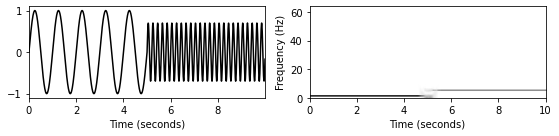

In [11]:
T_coef = np.arange(X.shape[1]) * H / Fs
F_coef = np.arange(X.shape[0]) * Fs / N

plt.figure(figsize=(8, 2))

plt.subplot(1, 2, 1)
plt.plot(t, x, c='k')
plt.xlim([min(t), max(t)])
plt.xlabel('Time (seconds)')

plt.subplot(1, 2, 2)
left = min(T_coef)
right = max(T_coef) + N / Fs
lower = min(F_coef)
upper = max(F_coef)
plt.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', 
           extent=[left, right, lower, upper])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()